https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/

https://www.analyticsvidhya.com/blog/2021/08/predict-the-next-word-of-your-text-using-long-short-term-memory-lstm/

https://jaketae.github.io/study/pytorch-rnn/

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from net import Net_CBOW
import torch.optim as optim
from matplotlib import pyplot as plt


In [28]:
version = "april22_3000datalim_20epoch"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = torch.load(f"saves/model_{version}.pt", map_location=device)
vocab = torch.load(f"saves/vocab_{version}.pt")
embeddings_df = torch.load(f"saves/emb_{version}.pt")
embeddings_norm = torch.Tensor(np.array(embeddings_df))


In [123]:
def embed(word):
    if word not in vocab:
        v = embeddings_df.loc["<unk>"]
    else:
        v = embeddings_df.loc[word]
    v = np.array(v)
    return v
def lookup_id(word, vocab=vocab):
    if word not in vocab:
        return vocab["<unk>"]
    return vocab[word]
def lookup_token(word_id, vocab=vocab):
    for word in vocab:
        if vocab[word] == word_id:
            return word
    return None
def get_top_similar(word_vec, embeddings_n = embeddings_norm, topN: int = 10, include_self=True):
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_n, word_vec).flatten()
    if not include_self:
        topN_ids = np.argsort(-dists)[1 : topN+1]
    else:
        topN_ids = np.argsort(-dists)[0 : topN]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = "<unk>"
        for k in vocab:
            if vocab[k] == sim_word_id:
                sim_word = k
                break
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict


In [121]:
get_top_similar(embeddings_df.loc["age"], topN=10)

tensor([408, 240, 112, 439, 386, 513, 360, 524, 345, 674])


{'age': tensor(1.),
 'university': tensor(0.8654),
 'end': tensor(0.8309),
 'roman': tensor(0.8190),
 'no.': tensor(0.8090),
 'archaeological': tensor(0.8087),
 'point': tensor(0.8050),
 'archaeology': tensor(0.7999),
 'period': tensor(0.7940),
 'front': tensor(0.7763)}

In [30]:
from datasets import load_dataset
wikitext2 = load_dataset("wikitext", "wikitext-2-v1")

In [31]:
text_train = wikitext2["train"]['text']
text_train = [item.lower().strip() for item in text_train if len(item) > 0]
text_test = wikitext2["test"]['text']
text_test = [item.lower().strip() for item in text_test if len(item) > 0]
len(text_train)

23767

In [32]:
text_train = [item.split(" ") + ["\n"] for item in text_train if "=" not in item]
text_test = [item.split(" ") + ["\n"] for item in text_test if "=" not in item]

In [55]:
enc_text_train = [[lookup_id(word) for word in paragraph] for paragraph in text_train]
enc_text_test = [[lookup_id(word) for word in paragraph] for paragraph in text_test]
len(enc_text_train)

17532

In [90]:
SCANNING_WINDOW = 10

def get_data(index, window, data):
    a = [float(a) for a in data[index-window:index]]
    x = []
    for word_id in a:
        x += list(embeddings_df.loc[lookup_token(word_id)])

    b = data[index]
    y = list(embeddings_df.loc[lookup_token(b)])
        
    return x, y

In [91]:
x_train = []
y_train = []
for paragraph in enc_text_train:
    for i in range(SCANNING_WINDOW, len(paragraph)):
        if paragraph[i] == vocab["<unk>"]:
            continue
        a, b = get_data(i, SCANNING_WINDOW, paragraph)
        x_train.append(a)
        y_train.append(b)
len(x_train)

Done collating training data. Moving on to test data.


In [ ]:
x_test = []
y_test = []
for paragraph in enc_text_test:
    for i in range(SCANNING_WINDOW, len(paragraph)):
        if paragraph[i] == vocab["<unk>"]:
            continue
        a, b = get_data(i, SCANNING_WINDOW, paragraph)
        x_test.append(a)
        y_test.append(b)
len(x_test)

In [291]:
EMBED_DIMENSION = 50
MIDDLE_LAYER = 100
class Predict(nn.Module):
    def __init__(self, scanning_window : int = SCANNING_WINDOW, embed_dimension : int = EMBED_DIMENSION):
        super(Predict, self).__init__()
        self.ln1 = nn.Linear(
            in_features=embed_dimension*scanning_window,
            out_features=MIDDLE_LAYER
        )
        self.ln2 = nn.Linear(
            in_features=MIDDLE_LAYER,
            out_features=embed_dimension
        )
    def forward(self, inputs):
        x = F.sigmoid(self.ln1(inputs))
        x = self.ln2(x)
        return x
    def predict(self, inputs):
        return F.softmax(self.forward(inputs))

In [292]:
net = Predict(SCANNING_WINDOW, EMBED_DIMENSION)
params = list(net.parameters())
net.zero_grad()
criterion = nn.CrossEntropyLoss()
losses = []
epoch_losses = []

In [293]:
NUM_EPOCHS = 20
optimizer = optim.Adam(net.parameters(), lr=0.025)
scheduler = optim.lr_scheduler.LinearLR(optimizer, 1.0, 0.0, total_iters=NUM_EPOCHS)

In [294]:
for epoch in range(NUM_EPOCHS):
    print("RUN", str(epoch+1)+"/"+str(NUM_EPOCHS), end=": ")
    for index in range(len(x_train[:1000])):
        if index % (len(x_train)//100) == 0:
            print("•", end="")

        context, target = x_train[index], y_train[index]
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(torch.tensor(context))
        loss = criterion(output, torch.tensor(target))
        loss.backward()
        optimizer.step()    # Does the update
    epoch_loss = 0
    for context, target in zip(x_test[:1000], y_test[:1000]):
    # for context, target in zip(x_train[:1000], y_train[:1000]):
        output = net(torch.tensor(context))
        losses.append(criterion(output, torch.tensor(target)).item())
        epoch_loss += losses[-1]
    epoch_loss /= len(x_test)
    epoch_losses.append(epoch_loss)
    
    print(f"[{epoch_loss}]")
    scheduler.step()
    print()

RUN 1/20: •[-46.60514457138998]

RUN 2/20: •[-90.54940175452629]

RUN 3/20: •[-132.2501689696321]

RUN 4/20: •[-171.66158684337682]

RUN 5/20: •[-208.84629845196514]

RUN 6/20: •[-243.84507644359445]

RUN 7/20: •[-276.6362647684267]

RUN 8/20: •[-307.2060397346955]

RUN 9/20: •[-335.4635582724364]

RUN 10/20: •[-361.4402188864306]

RUN 11/20: •[-385.11683312536593]

RUN 12/20: •[-406.50006213453815]

RUN 13/20: •[-425.5591591177277]

RUN 14/20: •[-442.2874240144611]

RUN 15/20: •[-456.6681063967632]

RUN 16/20: •[-468.68728485330155]

RUN 17/20: •[-478.3265010148843]

RUN 18/20: •[-485.57298924144027]

RUN 19/20: •[-490.41479898379265]

RUN 20/20: •[-492.84169773860657]



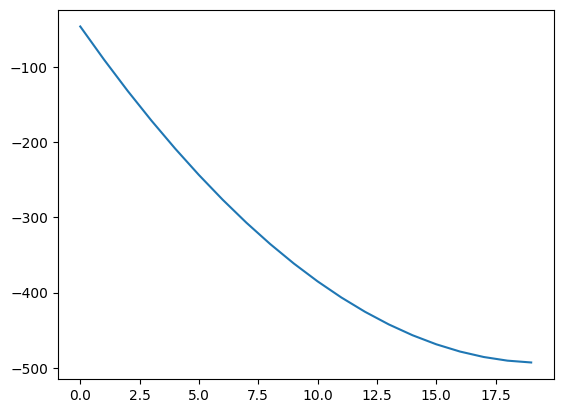

In [295]:
plt.plot(epoch_losses)
plt.show()


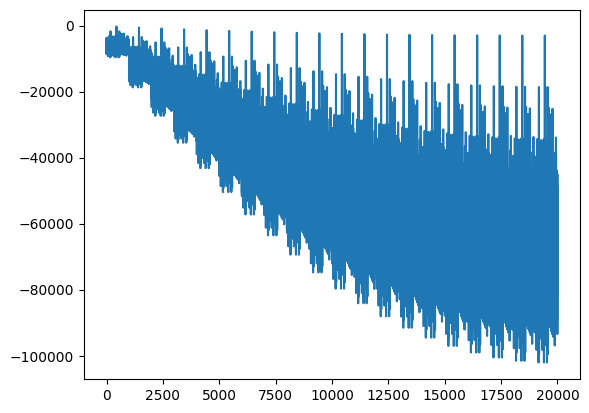

In [296]:
plt.plot(losses)
plt.show()

In [297]:
sentence = "the book and the novel are the best type of <unk>"
sentence = [vocab[a.lower()] for a in sentence.split(" ")]
index = 10
last_word = "of"
for i in range(10):
    context, middle = get_data(index + i, window=SCANNING_WINDOW, data=sentence)
    print('context',[list(get_top_similar(context[i*EMBED_DIMENSION:(i+1)*EMBED_DIMENSION], topN=1).keys())[0] for i in range(SCANNING_WINDOW)])
    predicted_word = list(get_top_similar(net.predict(torch.tensor(context)).detach(), topN=10).keys())
    print(predicted_word)
    predicted_word = predicted_word[0]
    # if predicted_word[0] == last_word:
    #     predicted_word = predicted_word[1]
    # else:
        # predicted_word = predicted_word[0]
    last_word = predicted_word
    sentence.insert(index + i, vocab[predicted_word])
    print([lookup_token(a) for a in sentence])

context ['the', 'book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of']
['community', 'institute', 'moved', 'army', 'began', 'return', 'week', 'canada', '13', 'move']
['the', 'book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', '<unk>']
context ['book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community']
['community', 'institute', 'moved', 'army', 'began', 'return', 'week', 'canada', '13', 'move']
['the', 'book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community', '<unk>']
context ['and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community']
['community', 'institute', 'moved', 'army', 'began', 'return', 'week', 'canada', '13', 'move']
['the', 'book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community', 'community', '<unk>']
context ['the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community', 'community']


/var/folders/r4/fbbvmvd16633t8bw5262q18c0000gn/T/ipykernel_58196/3414688340.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.forward(inputs))


['community', 'institute', 'moved', 'army', 'began', 'return', 'week', 'canada', '13', 'move']
['the', 'book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community', 'community', 'community', '<unk>']
context ['novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community', 'community', 'community']
['community', 'institute', 'moved', 'army', 'began', 'return', 'week', 'canada', '13', 'move']
['the', 'book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community', 'community', 'community', 'community', '<unk>']
context ['are', 'the', 'best', 'type', 'of', 'community', 'community', 'community', 'community', 'community']
['community', 'institute', 'moved', 'army', 'began', 'return', 'week', 'canada', '13', 'move']
['the', 'book', 'and', 'the', 'novel', 'are', 'the', 'best', 'type', 'of', 'community', 'community', 'community', 'community', 'community', 'community', '<unk>']
context ['the', 'best', 'type', 'of', 'community', '